# Using Traditional method to classify the fashio-data images

## Let's start with binary classification for easy calculation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

csv_path = 'dataset/fashion-dataset/styles.csv'

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path,
                    engine='python',
                    on_bad_lines='skip')
else:
    print('Error on the path to csv')

In [2]:
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


# Filter to only 2 classes and each only has 1000 images

In [3]:
df['masterCategory'].value_counts()

masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64

In [19]:
df['subCategory'].value_counts()

subCategory
Topwear                     15402
Shoes                        7343
Bags                         3055
Bottomwear                   2694
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Headwear                      293
Ties                          258
Accessories                   129
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    104
Stoles                         90
Skin Care                      77
Sk

In [4]:
df['articleType'].value_counts()

articleType
Tshirts                7067
Shirts                 3217
Casual Shoes           2845
Watches                2542
Sports Shoes           2036
                       ... 
Shoe Laces                1
Mens Grooming Kit         1
Body Wash and Scrub       1
Suits                     1
Ipad                      1
Name: count, Length: 143, dtype: int64

In [20]:
target_classes = ['Topwear','Shoes','Bottomwear', 'Bags','Watches']
index_map = {
    'Topwear' : 0,
    'Shoes' : 1,
    'Bottomwear': 2,
    'Bags' : 3,
    'Watches' : 4
}
df_filtered = df[df['subCategory'].isin(target_classes)]

df_filtered = df_filtered.groupby('subCategory').sample(n=1000, random_state=101)
df_filtered['subCategory'].value_counts()

subCategory
Bags          1000
Bottomwear    1000
Shoes         1000
Topwear       1000
Watches       1000
Name: count, dtype: int64

In [21]:
df_filtered.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
9543,34770,Women,Accessories,Bags,Handbags,Brown,Summer,2015.0,Casual,Be For Bag Women Zoli Brown Bag
31870,42937,Men,Accessories,Bags,Messenger Bag,Black,Summer,2012.0,Casual,French Connection Men Black Bag
15255,20567,Women,Accessories,Bags,Handbags,Gold,Winter,2015.0,Casual,Baggit Women Barbiex Avni Gold Handbag
624,47361,Women,Accessories,Bags,Handbags,Black,Summer,2012.0,Casual,Baggit Women Black Voodoo Gang Handbag
12872,44280,Unisex,Accessories,Bags,Backpacks,Black,Summer,2012.0,Casual,Skybags Unisex Black Backpack


# Get the numpy array of each image

In [148]:
from pathlib import Path
from PIL import Image
from sklearn.preprocessing import FunctionTransformer

def flatten_images(X):
    X = np.asarray(X)
    n_samples = X.shape[0]
    return X.reshape(n_samples, -1)

flatten = FunctionTransformer(flatten_images, validate=False)

image_dir = Path('dataset/fashion-dataset/images')
image_size = (128,128)

def imgExist(img_id):
    full_path = image_dir / f"{img_id}.jpg"
    return os.path.exists(full_path)

def load_gray_img(img_id, size = image_size):
    full_path = image_dir / f"{img_id}.jpg"
    with Image.open(full_path) as img:
        img = img.convert('L') #greyScale
        if image_size is not None:
            img = img.resize(image_size)
        arr = np.array(img)
        arr = arr.reshape(-1)
        return arr

In [149]:
mask = df_filtered['id'].apply(imgExist)
df_clean = df_filtered[mask].copy()

X = np.stack([load_gray_img(img_id, size=image_size) for img_id in df_clean['id'].values])
y = df_clean['subCategory'].map(index_map).to_numpy()


In [150]:
np.unique(y)

array([0, 1, 2, 3, 4], dtype=int64)

In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify=y, random_state=101)

# Create the workflow of training and backpropagation

In [152]:
n_in = len(X_train[0])
n_hidden = 64
n_out = len(target_classes)

W1 = np.random.rand(n_in, n_hidden)
b1 = np.zeros((1, n_hidden))

W2 = np.random.rand(n_hidden, n_out)
b2 = np.zeros((1, n_out))


In [154]:
import numpy as np

class NN:
    def __init__(self, input_size, hidden_size, output_size):
          self.input_size = input_size
          self.hidden_size = hidden_size
          self.output_size = output_size
          self.loss_history = []
          self.accuracy_history = []

          # Initialize weights
          self.weight_input_hidden = np.random.randn(
               self.input_size, self.hidden_size
          )
          self.weight_hidden_output = np.random.randn(
               self.hidden_size, self.output_size
          )
          
          self.bias_hidden = np.zeros((1, self.hidden_size))
          self.bias_output = np.zeros((1, self.output_size))
    
    def forward(self, X):
        self.hidden_activation = np.dot(X, self.weight_input_hidden) + self.bias_hidden
        self.hidden_output = self.sigmoid(self.hidden_activation)

        self.output_activation = np.dot(self.hidden_output, self.weight_hidden_output) + self.bias_output

        if self.output_size > 1 :
            self.predict_output = self.softmax(self.output_activation)
        else:
            self.predict_output = self.sigmoid(self.output_activation)

        return self.predict_output
    
    def backpropagate(self, X, y, lr):
        m = X.shape[0] # m = amount of data

        #Multi-class Classification
        if self.output_size > 1:
            #create y_hotcode
            if y.ndim == 1 or (y.ndim == 2 and y.shape[1] == 1):
                y_hotcode = np.zeros((m, self.output_size))
                position = y.flatten().astype(int)
                y_hotcode[np.arange(m), position] = 1
            else:
                y_hotcode = y
            
            output_delta = self.predict_output - y_hotcode

        #binary Classification
        else:
            if y.ndim == 1:
                y = y.reshape(-1,1)
            
            output_error = self.predict_output - y

            output_delta = output_error * self.sigmoid_derivative(self.predict_output)

        # calculate hidden layer error
        hidden_error = np.dot(output_delta, self.weight_hidden_output.T)
       
        hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_output)

        # Update Weights
        self.weight_hidden_output -= (np.dot(self.hidden_output.T, output_delta) / m) * lr
        self.bias_output -= (np.sum(output_delta, axis=0, keepdims=True) / m) * lr
        self.weight_input_hidden -= (np.dot(X.T, hidden_delta) / m) * lr
        self.bias_hidden -= (np.sum(hidden_delta, axis=0, keepdims=True) / m) * lr

    def train(self, X, y , epochs, lr):
        if y.ndim == 1:
            y = y.reshape(-1,1)

        for e in range(epochs):
            output = self.forward(X)
            self.backpropagate(X, y, lr)

            if e % 100 == 0:
                loss = 0
                if self.output_size > 1:

                    m = y.shape[0]
                    
                    acc = 0.0

                    if y.shape[1] == 1:
                         y_predictions = np.argmax(output, axis = 1)
                         y_true = y.flatten()
                         acc = np.mean(y_predictions == y_true)

                         y_hot = np.zeros((m, self.output_size))
                         y_hot[np.arange(m), y.flatten().astype(int)] = 1
                    else:
                         y_predictions = np.argmax(output, axis = 1)
                         y_true = np.argmax(y, axis=1)
                         acc = np.mean(y_predictions == y_true)

                         y_hot = y
                         
                    loss = -np.mean(np.sum(y_hot * np.log(output + 1e-8), axis=1))
                else:
                    #MSE Loss 
                    predicitions = np.round(output)
                    acc = np.mean(predicitions == y)
                    loss = np.mean(np.square(y - output))
                
                self.loss_history.append(loss)
                self.accuracy_history.append(acc)
                print(f'Epoch {e}, Loss: {loss:.8f}, accuracy: {acc:.8f}')

    def relu(self,x):
        return np.maximum(0,x)

    def sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) 
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [144]:
def SimpleScaler(X):
    #scale to ensure that the system doesn't overflow
        X = X.astype(np.float32) / 255.0
        return X

# Training Section

In [ ]:
nn28 = NN(input_size= 28*28, hidden_size=64, output_size=5)
nn28.train(X_train, y_train, epochs=3000, lr = 0.1)

C:\Users\User\AppData\Local\Temp\ipykernel_22848\1248395490.py:115: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Epoch 0, Loss: 4.23502008, accuracy: 0.21675000
Epoch 100, Loss: 0.92516308, accuracy: 0.66525000
Epoch 200, Loss: 0.80380733, accuracy: 0.71375000
Epoch 300, Loss: 0.72612897, accuracy: 0.73875000
Epoch 400, Loss: 0.69681114, accuracy: 0.74525000
Epoch 500, Loss: 0.68901731, accuracy: 0.73625000
Epoch 600, Loss: 0.62787443, accuracy: 0.76075000
Epoch 700, Loss: 0.62210144, accuracy: 0.79000000
Epoch 800, Loss: 0.55986327, accuracy: 0.81050000
Epoch 900, Loss: 0.54421155, accuracy: 0.81925000
Epoch 1000, Loss: 0.53462367, accuracy: 0.81300000
Epoch 1100, Loss: 0.52683704, accuracy: 0.82800000
Epoch 1200, Loss: 0.50686352, accuracy: 0.83300000
Epoch 1300, Loss: 0.48838727, accuracy: 0.83775000
Epoch 1400, Loss: 0.47519085, accuracy: 0.84325000
Epoch 1500, Loss: 0.47121274, accuracy: 0.84400000
Epoch 1600, Loss: 0.45406454, accuracy: 0.85150000
Epoch 1700, Loss: 0.52868151, accuracy: 0.82150000
Epoch 1800, Loss: 0.45249641, accuracy: 0.84850000
Epoch 1900, Loss: 0.45147692, accuracy: 0.8

In [ ]:
nn32 = NN(input_size= 32*32, hidden_size=64, output_size=5)
nn32.train(X_train, y_train, epochs=3000, lr = 0.1)

C:\Users\User\AppData\Local\Temp\ipykernel_22848\1248395490.py:115: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Epoch 0, Loss: 9.87568786, accuracy: 0.20000000
Epoch 100, Loss: 1.05267817, accuracy: 0.60600000
Epoch 200, Loss: 0.84025220, accuracy: 0.67475000
Epoch 300, Loss: 0.73733727, accuracy: 0.71725000
Epoch 400, Loss: 0.72807257, accuracy: 0.72325000
Epoch 500, Loss: 0.67014368, accuracy: 0.73675000
Epoch 600, Loss: 0.61699524, accuracy: 0.75275000
Epoch 700, Loss: 0.57882682, accuracy: 0.77300000
Epoch 800, Loss: 0.56083915, accuracy: 0.77950000
Epoch 900, Loss: 0.53226210, accuracy: 0.81200000
Epoch 1000, Loss: 0.53389544, accuracy: 0.80250000
Epoch 1100, Loss: 0.50811726, accuracy: 0.81275000
Epoch 1200, Loss: 0.50991192, accuracy: 0.81350000
Epoch 1300, Loss: 0.48325351, accuracy: 0.81700000
Epoch 1400, Loss: 0.50588444, accuracy: 0.80675000
Epoch 1500, Loss: 0.48699639, accuracy: 0.81375000
Epoch 1600, Loss: 0.49985187, accuracy: 0.83050000
Epoch 1700, Loss: 0.44467633, accuracy: 0.83800000
Epoch 1800, Loss: 0.45888648, accuracy: 0.83100000
Epoch 1900, Loss: 0.44007942, accuracy: 0.8

In [ ]:
X_train = SimpleScaler(X_train)
X_test = SimpleScaler(X_test)

nn64 = NN(input_size= 64*64, hidden_size=64, output_size=5)
nn64.train(X_train, y_train, epochs=3000, lr = 0.1)


Epoch 0, Loss: 7.65359902, accuracy: 0.19950000
Epoch 100, Loss: 1.03817581, accuracy: 0.64475000
Epoch 200, Loss: 0.84622554, accuracy: 0.71850000
Epoch 300, Loss: 0.72497347, accuracy: 0.76200000
Epoch 400, Loss: 0.63413665, accuracy: 0.78800000
Epoch 500, Loss: 0.56588772, accuracy: 0.81000000
Epoch 600, Loss: 0.51296056, accuracy: 0.82800000
Epoch 700, Loss: 0.47374646, accuracy: 0.84325000
Epoch 800, Loss: 0.44417142, accuracy: 0.85375000
Epoch 900, Loss: 0.41985440, accuracy: 0.86350000
Epoch 1000, Loss: 0.39834613, accuracy: 0.86975000
Epoch 1100, Loss: 0.37908515, accuracy: 0.87450000
Epoch 1200, Loss: 0.35933185, accuracy: 0.88275000
Epoch 1300, Loss: 0.33989081, accuracy: 0.88900000
Epoch 1400, Loss: 0.32607997, accuracy: 0.89300000
Epoch 1500, Loss: 0.31427896, accuracy: 0.89725000
Epoch 1600, Loss: 0.30393721, accuracy: 0.90175000
Epoch 1700, Loss: 0.29453945, accuracy: 0.90350000
Epoch 1800, Loss: 0.28579019, accuracy: 0.90525000
Epoch 1900, Loss: 0.27753950, accuracy: 0.9

In [ ]:
nn128 = NN(input_size= 128*128, hidden_size=64, output_size=5)
nn128.train(X_train, y_train, epochs=3000, lr = 0.1)

C:\Users\User\AppData\Local\Temp\ipykernel_22848\1248395490.py:115: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Epoch 0, Loss: 4.35366339, accuracy: 0.18050000
Epoch 100, Loss: 1.42881799, accuracy: 0.41175000
Epoch 200, Loss: 1.24581527, accuracy: 0.51600000
Epoch 300, Loss: 1.14444523, accuracy: 0.56850000
Epoch 400, Loss: 1.10066502, accuracy: 0.58025000
Epoch 500, Loss: 1.05837433, accuracy: 0.59625000
Epoch 600, Loss: 1.04063957, accuracy: 0.58700000
Epoch 700, Loss: 1.01987435, accuracy: 0.58575000
Epoch 800, Loss: 1.05866545, accuracy: 0.57775000
Epoch 900, Loss: 1.04021181, accuracy: 0.59050000
Epoch 1000, Loss: 1.01527919, accuracy: 0.61050000
Epoch 1100, Loss: 1.00076763, accuracy: 0.62025000
Epoch 1200, Loss: 0.98986802, accuracy: 0.62425000
Epoch 1300, Loss: 0.98096525, accuracy: 0.63300000
Epoch 1400, Loss: 0.97275818, accuracy: 0.63475000
Epoch 1500, Loss: 0.96615192, accuracy: 0.63900000
Epoch 1600, Loss: 0.96074700, accuracy: 0.63975000
Epoch 1700, Loss: 0.95605326, accuracy: 0.64175000
Epoch 1800, Loss: 0.95193149, accuracy: 0.64250000
Epoch 1900, Loss: 0.94827654, accuracy: 0.6

# Evaluate part of hidden layer size = 64

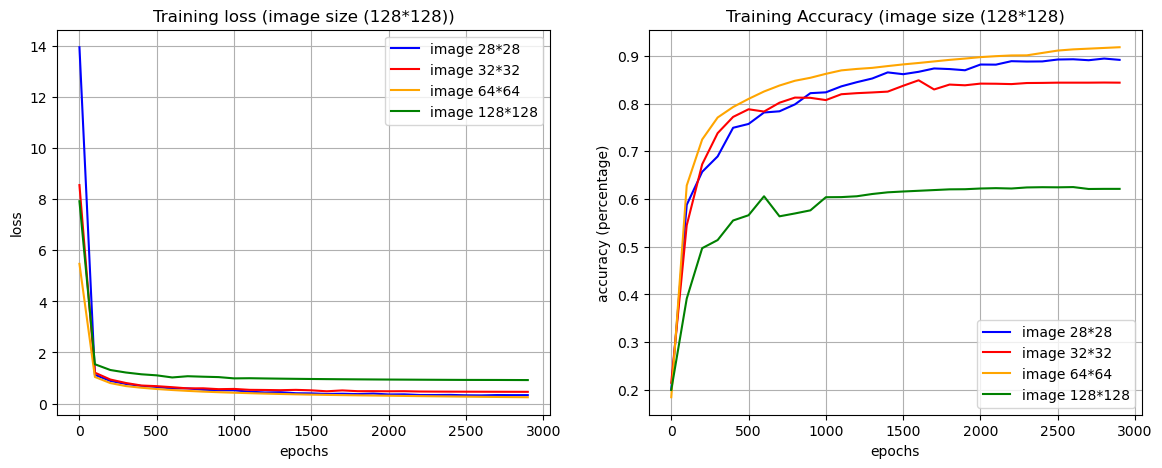

In [138]:
import matplotlib.pyplot as plt

epochs_range = [i * 100 for i in range(len(nn32.loss_history))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs_range, nn28.loss_history, color = 'blue', label = 'image 28*28')
ax1.plot(epochs_range, nn32.loss_history, color = 'red', label = 'image 32*32')
ax1.plot(epochs_range, nn64.loss_history, color = 'orange', label = 'image 64*64')
ax1.plot(epochs_range, nn128.loss_history, color = 'green', label = 'image 128*128')
ax1.set_title("Training loss (image size (128*128))")
ax1.set_xlabel("epochs")
ax1.set_ylabel('loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs_range, nn28.accuracy_history, color = 'blue', label = 'image 28*28')
ax2.plot(epochs_range, nn32.accuracy_history, color = 'red', label = 'image 32*32')
ax2.plot(epochs_range, nn64.accuracy_history, color = 'orange', label = 'image 64*64')
ax2.plot(epochs_range, nn128.accuracy_history, color = 'green', label = 'image 128*128')
ax2.set_title("Training Accuracy (image size (128*128)")
ax2.set_xlabel("epochs")
ax2.set_ylabel('accuracy (percentage)')
ax2.legend()
ax2.grid(True)

plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_test_prob = nn64.forward(X_test)

y_test_pred = np.argmax(y_test_prob, axis=1)
y_test_pred = y_test_pred.reshape(-1)

model_accuracy = np.mean(y_test == y_test_pred)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       200
           1       0.97      0.98      0.97       200
           2       0.94      0.92      0.93       200
           3       0.93      0.95      0.94       200
           4       0.92      0.93      0.93       200

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [82]:
y_test_prob_28 = nn28.forward(X_test)
y_test_pred_28 = np.argmax(y_test_prob_28, axis=1)
y_test_pred_28 = y_test_pred_28.reshape(-1)
model_accuracy_28 = np.mean(y_test == y_test_pred_28)
print(f"Acc 28: {model_accuracy_28:.4f}")

Acc 28: 0.8340


C:\Users\User\AppData\Local\Temp\ipykernel_22848\1248395490.py:115: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [90]:
y_test_prob_32 = nn32.forward(X_test)
y_test_pred_32 = np.argmax(y_test_prob_32, axis=1)
y_test_pred_32 = y_test_pred_32.reshape(-1)
model_accuracy_32 = np.mean(y_test == y_test_pred_32)
print(f"Acc 32: {model_accuracy_32:.4f}")

Acc 32: 0.8600


C:\Users\User\AppData\Local\Temp\ipykernel_22848\1248395490.py:115: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [99]:
y_test_prob_64 = nn64.forward(X_test)
y_test_pred_64 = np.argmax(y_test_prob_64, axis=1)
y_test_pred_64 = y_test_pred_64.reshape(-1)
model_accuracy_64 = np.mean(y_test == y_test_pred_64)
print(f"Acc 64: {model_accuracy_64:.4f}")

Acc 64: 0.9250


C:\Users\User\AppData\Local\Temp\ipykernel_22848\1248395490.py:115: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [110]:
y_test_prob_128 = nn128.forward(X_test)
y_test_pred_128 = np.argmax(y_test_prob_128, axis=1)
y_test_pred_128 = y_test_pred_128.reshape(-1)
model_accuracy_128 = np.mean(y_test == y_test_pred_128) # Changed to _128
print(f"Acc 128: {model_accuracy_128:.4f}")

Acc 128: 0.6470


C:\Users\User\AppData\Local\Temp\ipykernel_22848\1248395490.py:115: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [112]:
print(f"Test Accuracy 28*28: {model_accuracy_28:.4f}")
print(f"Test Accuracy 32*32: {model_accuracy_32:.4f}")
print(f"Test Accuracy 64*64: {model_accuracy_64:.4f}")
print(f"Test Accuracy 128*128: {model_accuracy_128:.4f}")

Test Accuracy 28*28: 0.8340
Test Accuracy 32*32: 0.8600
Test Accuracy 64*64: 0.9250
Test Accuracy 128*128: 0.6470


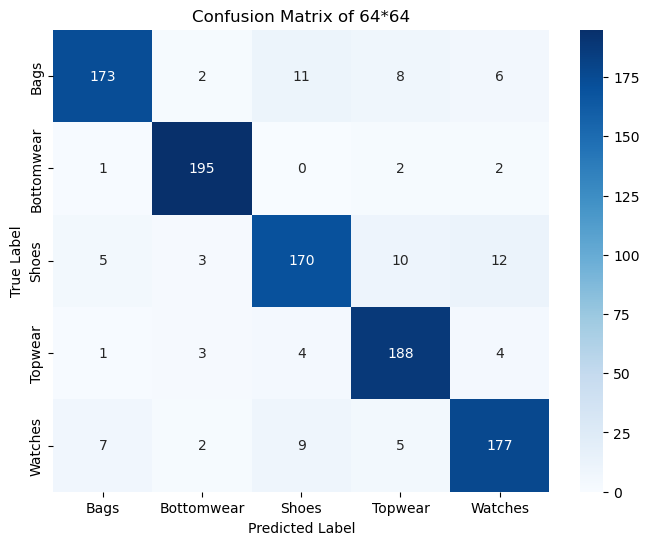

In [149]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Watches']
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
plt.title("Confusion Matrix of 64*64")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Try Using hidden_layer_size = 32

In [ ]:
X_train = SimpleScaler(X_train)
X_test = SimpleScaler(X_test)
nn28_32 = NN(input_size= 28*28, hidden_size=32, output_size=5)
nn28_32.train(X_train, y_train, epochs=3000, lr = 0.1)

Epoch 0, Loss: 5.71641545, accuracy: 0.20150000
Epoch 100, Loss: 1.40204876, accuracy: 0.40625000
Epoch 200, Loss: 1.28733059, accuracy: 0.48850000
Epoch 300, Loss: 1.18096011, accuracy: 0.55675000
Epoch 400, Loss: 1.06890887, accuracy: 0.62975000
Epoch 500, Loss: 0.92283702, accuracy: 0.71450000
Epoch 600, Loss: 0.80588135, accuracy: 0.75750000
Epoch 700, Loss: 0.71595107, accuracy: 0.78300000
Epoch 800, Loss: 0.64182273, accuracy: 0.80725000
Epoch 900, Loss: 0.58175867, accuracy: 0.82550000
Epoch 1000, Loss: 0.53270824, accuracy: 0.84025000
Epoch 1100, Loss: 0.49180778, accuracy: 0.85375000
Epoch 1200, Loss: 0.45685644, accuracy: 0.86800000
Epoch 1300, Loss: 0.42671162, accuracy: 0.88000000
Epoch 1400, Loss: 0.40114679, accuracy: 0.88625000
Epoch 1500, Loss: 0.37977173, accuracy: 0.89025000
Epoch 1600, Loss: 0.36167770, accuracy: 0.89375000
Epoch 1700, Loss: 0.34603576, accuracy: 0.89800000
Epoch 1800, Loss: 0.33228023, accuracy: 0.90175000
Epoch 1900, Loss: 0.32004928, accuracy: 0.9

In [134]:
X_train = SimpleScaler(X_train)
X_test = SimpleScaler(X_test)
nn32_32 = NN(input_size= 32*32, hidden_size=32, output_size=5)
nn32_32.train(X_train, y_train, epochs=3000, lr = 0.1)

Epoch 0, Loss: 3.19007421, accuracy: 0.22700000
Epoch 100, Loss: 1.14224946, accuracy: 0.61050000
Epoch 200, Loss: 0.96532636, accuracy: 0.63575000
Epoch 300, Loss: 0.86526338, accuracy: 0.66625000
Epoch 400, Loss: 0.79000422, accuracy: 0.69675000
Epoch 500, Loss: 0.72336061, accuracy: 0.71850000
Epoch 600, Loss: 0.66536759, accuracy: 0.75000000
Epoch 700, Loss: 0.61658586, accuracy: 0.78025000
Epoch 800, Loss: 0.57507292, accuracy: 0.80325000
Epoch 900, Loss: 0.53839487, accuracy: 0.82050000
Epoch 1000, Loss: 0.50577054, accuracy: 0.83825000
Epoch 1100, Loss: 0.47697303, accuracy: 0.84950000
Epoch 1200, Loss: 0.45017693, accuracy: 0.85575000
Epoch 1300, Loss: 0.42347813, accuracy: 0.86500000
Epoch 1400, Loss: 0.40396034, accuracy: 0.87350000
Epoch 1500, Loss: 0.38701174, accuracy: 0.88000000
Epoch 1600, Loss: 0.37207179, accuracy: 0.88325000
Epoch 1700, Loss: 0.35890979, accuracy: 0.88725000
Epoch 1800, Loss: 0.34734399, accuracy: 0.88975000
Epoch 1900, Loss: 0.33711230, accuracy: 0.8

In [145]:
X_train = SimpleScaler(X_train)
X_test = SimpleScaler(X_test)
nn64_32 = NN(input_size= 64*64, hidden_size=32, output_size=5)
nn64_32.train(X_train, y_train, epochs=3000, lr = 0.1)

Epoch 0, Loss: 6.76389349, accuracy: 0.19900000
Epoch 100, Loss: 0.98878543, accuracy: 0.64125000
Epoch 200, Loss: 0.84264581, accuracy: 0.71075000
Epoch 300, Loss: 0.74714008, accuracy: 0.74775000
Epoch 400, Loss: 0.68130591, accuracy: 0.76925000
Epoch 500, Loss: 0.62276599, accuracy: 0.79125000
Epoch 600, Loss: 0.57347134, accuracy: 0.81325000
Epoch 700, Loss: 0.52965221, accuracy: 0.82800000
Epoch 800, Loss: 0.49597907, accuracy: 0.83950000
Epoch 900, Loss: 0.46850262, accuracy: 0.85025000
Epoch 1000, Loss: 0.44483987, accuracy: 0.85975000
Epoch 1100, Loss: 0.42468089, accuracy: 0.86725000
Epoch 1200, Loss: 0.40690388, accuracy: 0.87225000
Epoch 1300, Loss: 0.39089065, accuracy: 0.87625000
Epoch 1400, Loss: 0.37638672, accuracy: 0.88125000
Epoch 1500, Loss: 0.36339908, accuracy: 0.88525000
Epoch 1600, Loss: 0.35166522, accuracy: 0.88825000
Epoch 1700, Loss: 0.34090099, accuracy: 0.89225000
Epoch 1800, Loss: 0.33101520, accuracy: 0.89550000
Epoch 1900, Loss: 0.32189214, accuracy: 0.8

In [156]:
X_train = SimpleScaler(X_train)
X_test = SimpleScaler(X_test)
nn128_32 = NN(input_size= 128*128, hidden_size=32, output_size=5)
nn128_32.train(X_train, y_train, epochs=3000, lr = 0.1)

Epoch 0, Loss: 2.36355993, accuracy: 0.15525000
Epoch 100, Loss: 1.56346044, accuracy: 0.30150000
Epoch 200, Loss: 1.53849548, accuracy: 0.33250000
Epoch 300, Loss: 1.51404662, accuracy: 0.37300000
Epoch 400, Loss: 1.48998830, accuracy: 0.40650000
Epoch 500, Loss: 1.46622257, accuracy: 0.44300000
Epoch 600, Loss: 1.44267729, accuracy: 0.47525000
Epoch 700, Loss: 1.41930389, accuracy: 0.50150000
Epoch 800, Loss: 1.39607471, accuracy: 0.52975000
Epoch 900, Loss: 1.37297994, accuracy: 0.55325000
Epoch 1000, Loss: 1.35002438, accuracy: 0.57175000
Epoch 1100, Loss: 1.32722418, accuracy: 0.59125000
Epoch 1200, Loss: 1.30460387, accuracy: 0.61125000
Epoch 1300, Loss: 1.28219362, accuracy: 0.62875000
Epoch 1400, Loss: 1.26002705, accuracy: 0.64675000
Epoch 1500, Loss: 1.23813934, accuracy: 0.66400000
Epoch 1600, Loss: 1.21656575, accuracy: 0.68200000
Epoch 1700, Loss: 1.19534039, accuracy: 0.69475000
Epoch 1800, Loss: 1.17449516, accuracy: 0.71075000
Epoch 1900, Loss: 1.15405893, accuracy: 0.7

# Evaluate part of hidden layer size = 64

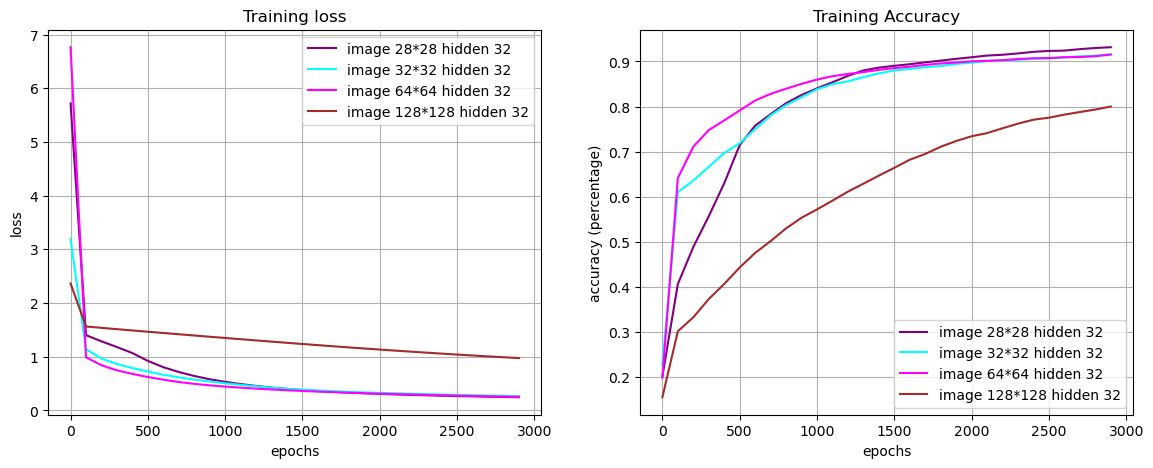

In [176]:

epochs_range = [i * 100 for i in range(len(nn32.loss_history))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs_range, nn28_32.loss_history, color = 'purple', label = 'image 28*28 hidden 32')
ax1.plot(epochs_range, nn32_32.loss_history, color = 'cyan', label = 'image 32*32 hidden 32')
ax1.plot(epochs_range, nn64_32.loss_history, color = 'magenta', label = 'image 64*64 hidden 32')
ax1.plot(epochs_range, nn128_32.loss_history, color = 'brown', label = 'image 128*128 hidden 32')
ax1.set_title("Training loss")
ax1.set_xlabel("epochs")
ax1.set_ylabel('loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs_range, nn28_32.accuracy_history, color = 'purple', label = 'image 28*28 hidden 32')
ax2.plot(epochs_range, nn32_32.accuracy_history, color = 'cyan', label = 'image 32*32 hidden 32')
ax2.plot(epochs_range, nn64_32.accuracy_history, color = 'magenta', label = 'image 64*64 hidden 32')
ax2.plot(epochs_range, nn128_32.accuracy_history, color = 'brown', label = 'image 128*128 hidden 32')
ax2.set_title("Training Accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylabel('accuracy (percentage)')
ax2.legend()
ax2.grid(True)

plt.show()

# # Evaluate part of all hidden layer sizes

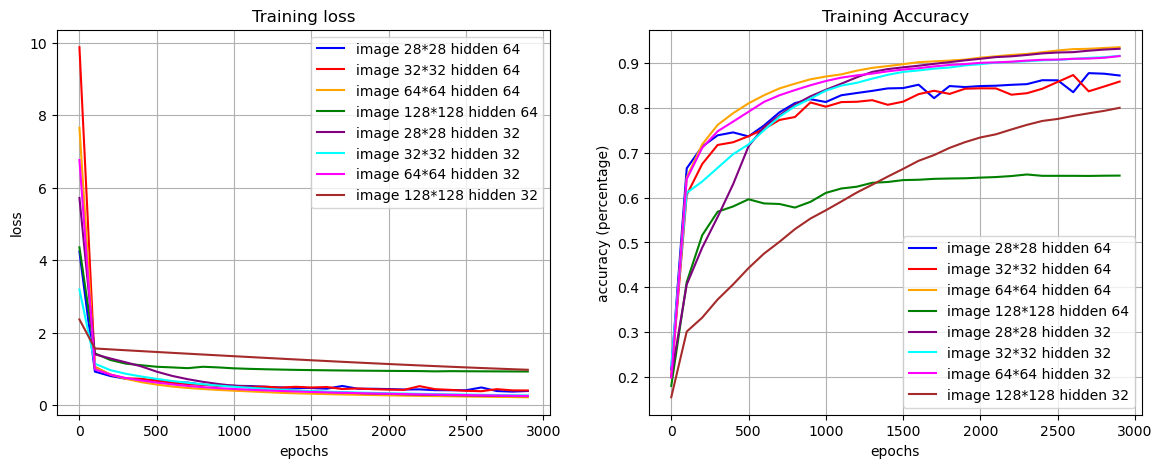

In [ ]:

epochs_range = [i * 100 for i in range(len(nn32.loss_history))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs_range, nn28.loss_history, color = 'blue', label = 'image 28*28 hidden 64')
ax1.plot(epochs_range, nn32.loss_history, color = 'red', label = 'image 32*32 hidden 64')
ax1.plot(epochs_range, nn64.loss_history, color = 'orange', label = 'image 64*64 hidden 64')
ax1.plot(epochs_range, nn128.loss_history, color = 'green', label = 'image 128*128 hidden 64')

ax1.plot(epochs_range, nn28_32.loss_history, color = 'purple', label = 'image 28*28 hidden 32')
ax1.plot(epochs_range, nn32_32.loss_history, color = 'cyan', label = 'image 32*32 hidden 32')
ax1.plot(epochs_range, nn64_32.loss_history, color = 'magenta', label = 'image 64*64 hidden 32')
ax1.plot(epochs_range, nn128_32.loss_history, color = 'brown', label = 'image 128*128 hidden 32')
ax1.set_title("Training loss")
ax1.set_xlabel("epochs")
ax1.set_ylabel('loss')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs_range, nn28.accuracy_history, color = 'blue', label = 'image 28*28 hidden 64')
ax2.plot(epochs_range, nn32.accuracy_history, color = 'red', label = 'image 32*32 hidden 64')
ax2.plot(epochs_range, nn64.accuracy_history, color = 'orange', label = 'image 64*64 hidden 64')
ax2.plot(epochs_range, nn128.accuracy_history, color = 'green', label = 'image 128*128 hidden 64')

ax2.plot(epochs_range, nn28_32.accuracy_history, color = 'purple', label = 'image 28*28 hidden 32')
ax2.plot(epochs_range, nn32_32.accuracy_history, color = 'cyan', label = 'image 32*32 hidden 32')
ax2.plot(epochs_range, nn64_32.accuracy_history, color = 'magenta', label = 'image 64*64 hidden 32')
ax2.plot(epochs_range, nn128_32.accuracy_history, color = 'brown', label = 'image 128*128 hidden 32')
ax2.set_title("Training Accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylabel('accuracy (percentage)')
ax2.legend()
ax2.grid(True)

plt.show()

In [ ]:
#For model input = 28*28 hidden_n = 32
y_test_prob_28_32 = nn28_32.forward(X_test)
y_test_pred_28_32 = np.argmax(y_test_prob_28_32, axis=1)
y_test_pred_28_32 = y_test_pred_28_32.reshape(-1)
model_accuracy_28_32 = np.mean(y_test == y_test_pred_28)
print(f"Acc 28_32: {model_accuracy_28_32:.4f}")

Acc 128: 0.8340


In [ ]:
#For model input = 32*32 hidden_n = 32
y_test_prob_32_32 = nn32_32.forward(X_test)
y_test_pred_32_32 = np.argmax(y_test_prob_32_32, axis=1)
y_test_pred_32_32 = y_test_pred_32_32.reshape(-1)
model_accuracy_32_32 = np.mean(y_test == y_test_pred_32_32)
print(f"Acc 32_32: {model_accuracy_32_32:.4f}")

Acc 32_32: 0.9180


In [147]:
#For model input = 64*64 hidden_n = 32
y_test_prob_64_32 = nn64_32.forward(X_test)
y_test_pred_64_32 = np.argmax(y_test_prob_64_32, axis=1)
y_test_pred_64_32 = y_test_pred_64_32.reshape(-1)
model_accuracy_64_32 = np.mean(y_test == y_test_pred_64_32)
print(f"Acc 64_32: {model_accuracy_64_32:.4f}")

Acc 64_32: 0.9200


In [158]:
#For model input = 128*128 hidden_n = 32
y_test_prob_128_32 = nn128_32.forward(X_test)
y_test_pred_128_32 = np.argmax(y_test_prob_128_32, axis=1)
y_test_pred_128_32 = y_test_pred_128_32.reshape(-1)
model_accuracy_128_32 = np.mean(y_test == y_test_pred_128_32)
print(f"Acc 128_32: {model_accuracy_128_32:.4f}")

Acc 128_32: 0.8140


In [175]:
print("============== hidden_size : 32 ==============")
print(f"Test Accuracy input(28*28): {model_accuracy_28_32:.4f}")
print(f"Test Accuracy input(32*32): {model_accuracy_32_32:.4f}")
print(f"Test Accuracy input(64*64): {model_accuracy_64_32:.4f}")
print(f"Test Accuracy input(128*128): {model_accuracy_128_32:.4f}")
print("============== hidden_size : 64 ==============")
print(f"Test Accuracy input(28*28): {model_accuracy_28:.4f}")
print(f"Test Accuracy input(32*32): {model_accuracy_32:.4f}")
print(f"Test Accuracy input(64*64): {model_accuracy_64:.4f}")
print(f"Test Accuracy input(128*128): {model_accuracy_128:.4f}")

============== hidden_size : 32 ==============
Test Accuracy input(28*28): 0.8340
Test Accuracy input(32*32): 0.9180
Test Accuracy input(64*64): 0.9200
Test Accuracy input(128*128): 0.8140
============== hidden_size : 64 ==============
Test Accuracy input(28*28): 0.8340
Test Accuracy input(32*32): 0.8600
Test Accuracy input(64*64): 0.9250
Test Accuracy input(128*128): 0.6470
